<a href="https://colab.research.google.com/github/sanjeevrs2000/CS6910-Assignment-2/blob/main/Assignment_2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     |████████████████████████████████| 2.1MB 20.2MB/s 
     |████████████████████████████████| 163kB 56.5MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 133kB 52.6MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=5be545a803c71e0c5f21698aaccfab9468d805ab88b0d25306505285de0a886d
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=fc9fa6fb161822fe61d6530c63d57eaa17407de060379eaf2b4d0c8ee40cd3bd
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [ ]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

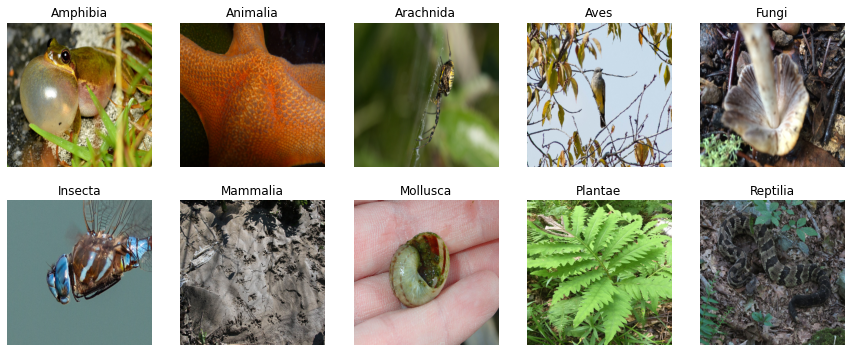

In [58]:
#visualizing images 
fig = plt.figure(figsize=(15,6))
rows,columns=2,5
i=1
for category in categories:
  dir=os.path.join(train_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(category)
    i+=1   
    break
  

In [62]:
sweep_config = {
  'name': 'sweep7',  
  'method': 'grid',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes']   
        },
        'droprate':{
            'values':[0.4,0.5]
        }
           
    }

}

config_defaults={
    'filters':'inc',
    'fc_size':256,
    'batchnorm':'yes',
    'augmentation':'no',
    'droprate':0.3
}

In [63]:
def Train_CNN():

  #wandb.init(config=config_defaults)
  #configs=wandb.config

  configs=config_defaults

  batchnorm=configs['batchnorm']
  droprate=configs['droprate']
  augmentation=configs['augmentation']
  filter_=configs['filters']
  fc_size=configs['fc_size']

  #wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')

  if filter_ == 'all_64':
    filters=[64,64,64,64,64]
  elif filter_=='all_32' :
    filters=[32,32,32,32,32]
  elif filter_=='inc' :
    filters=[16,32,64,128,256]
  elif filter_ == 'dec' :
    filters=[128,64,32,16,8]
  elif filter_ =='inc_dec':
    filters=[32,64,128,64,32]
  elif filter_ =='dec_inc' :
    filters=[128,64,32,64,128]


  img_height,img_width=300,300

  model=models.Sequential()

  model.add(Conv2D(filters[0], (3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[1], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[2], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[3], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[4], (3, 3),activation='relu'))
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(fc_size,activation='relu')) 
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(Dropout(droprate))

  model.add(Dense(10,activation='softmax'))

  #data generators for train(with and without augmentation) and validation set
  augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
  )

  aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
  )

  val_set = datagen.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='validation',
      seed=123,
  )

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

  if augmentation =='no' :
    #hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(train_set,epochs=10,validation_data=val_set)

  else:
    #hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(aug_set,epochs=10,validation_data=val_set)
  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_acc':val_acc}
  #wandb.log(params)

In [ ]:
#Ignore this 
#sweep_id=wandb.sweep(sweep_config,entity='sanjeev-nimeesh',project='assignment_2')
#wandb.agent(sweep_id, Train_CNN)         

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ykkve53v
Sweep URL: https://wandb.ai/sanjeev-nimeesh/assignment_2/sweeps/ykkve53v


wandb: Agent Starting Run: glg6jqf9 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: inc_dec
wandb: Currently logged in as: sanjeevrs (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 356s 1s/step - loss: 2.7921 - accuracy: 0.1506 - val_loss: 2.6423 - val_accuracy: 0.1411
Epoch 2/10
282/282 [==============================] - 320s 1s/step - loss: 2.3095 - accuracy: 0.2165 - val_loss: 2.2483 - val_accuracy: 0.1992
Epoch 3/10
282/282 [==============================] - 316s 1s/step - loss: 2.2039 - accuracy: 0.2356 - val_loss: 2.3181 - val_accuracy: 0.2402
Epoch 4/10
282/282 [==============================] - 318s 1s/step - loss: 2.0908 - accuracy: 0.2626 - val_loss: 2.0112 - val_accuracy: 0.2743
Epoch 5/10
282/282 [==============================] - 326s 1s/step - loss: 2.0346 - accuracy: 0.2685 - val_loss: 2.0602 - val_accuracy: 0.2903
Epoch 6/10
282/282 [==============================] - 325s 1s/step - loss: 1.9749 - accuracy: 0.2969 - val_loss: 2.1058 - val_accuracy: 0.2963
Epoch 7/10
282

epoch,9
loss,1.90389
accuracy,0.319
val_loss,1.97717
val_accuracy,0.31932
_runtime,3284
_timestamp,1618149505
_step,10
best_val_loss,1.97717
best_epoch,9
batch_norm,yes


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▄▅▁▂▂▅▁▁▁
val_accuracy,▁▃▅▆▇▇▄▇▇█
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
dropout,▁
val_acc,▁


wandb: Agent Starting Run: 79fdnc9g with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 370s 1s/step - loss: 2.7396 - accuracy: 0.1464 - val_loss: 3.5488 - val_accuracy: 0.1001
Epoch 2/10
282/282 [==============================] - 361s 1s/step - loss: 2.3174 - accuracy: 0.2040 - val_loss: 2.2948 - val_accuracy: 0.1872
Epoch 3/10
282/282 [==============================] - 358s 1s/step - loss: 2.1532 - accuracy: 0.2405 - val_loss: 2.1605 - val_accuracy: 0.2412
Epoch 4/10
282/282 [==============================] - 364s 1s/step - loss: 2.0889 - accuracy: 0.2589 - val_loss: 2.0679 - val_accuracy: 0.2893
Epoch 5/10
282/282 [==============================] - 365s 1s/step - loss: 2.0035 - accuracy: 0.2833 - val_loss: 2.0750 - val_accuracy: 0.3083
Epoch 6/10
282/282 [==============================] - 364s 1s/step - loss: 1.9897 - accuracy: 0.2954 - val_loss: 1.9644 - val_accuracy: 0.3223
Epoch 7/10
282

epoch,9
loss,1.88778
accuracy,0.32467
val_loss,2.0048
val_accuracy,0.2953
_runtime,3645
_timestamp,1618153163
_step,10
best_val_loss,1.93023
best_epoch,7
batch_norm,yes


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▃▂▂▂▁▁▁▃▁
val_accuracy,▁▄▅▇▇███▆▇
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
dropout,▁
val_acc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 00xlzzre with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 339s 1s/step - loss: 3.0640 - accuracy: 0.1356 - val_loss: 2.9132 - val_accuracy: 0.1081
Epoch 2/10
282/282 [==============================] - 339s 1s/step - loss: 2.4394 - accuracy: 0.1854 - val_loss: 2.1377 - val_accuracy: 0.2352
Epoch 3/10
282/282 [==============================] - 338s 1s/step - loss: 2.2243 - accuracy: 0.2250 - val_loss: 2.0776 - val_accuracy: 0.2693
Epoch 4/10
282/282 [==============================] - 336s 1s/step - loss: 2.1321 - accuracy: 0.2512 - val_loss: 2.0367 - val_accuracy: 0.2843
Epoch 5/10
282/282 [==============================] - 339s 1s/step - loss: 2.0739 - accuracy: 0.2511 - val_loss: 2.0326 - val_accuracy: 0.2913
Epoch 6/10
282/282 [==============================] - 341s 1s/step - loss: 2.0023 - accuracy: 0.2795 - val_loss: 2.0855 - val_accuracy: 0.2663
Epoch 7/10
282

epoch,9
loss,1.925
accuracy,0.30633
val_loss,1.87496
val_accuracy,0.33734
_runtime,3369
_timestamp,1618156558
_step,10
best_val_loss,1.87496
best_epoch,9
batch_norm,yes


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
accuracy,▁▃▄▆▆▇▇▇██
val_loss,█▃▂▂▂▂▂▁▂▁
val_accuracy,▁▅▆▆▆▆▇█▆█
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
dropout,▁
val_acc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mikdlktf with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 379s 1s/step - loss: 2.9521 - accuracy: 0.1490 - val_loss: 2.4960 - val_accuracy: 0.1512
Epoch 2/10
282/282 [==============================] - 372s 1s/step - loss: 2.4221 - accuracy: 0.1907 - val_loss: 2.0895 - val_accuracy: 0.2482
Epoch 3/10
282/282 [==============================] - 373s 1s/step - loss: 2.2196 - accuracy: 0.2219 - val_loss: 2.2483 - val_accuracy: 0.2232
Epoch 4/10
282/282 [==============================] - 372s 1s/step - loss: 2.1372 - accuracy: 0.2381 - val_loss: 2.1231 - val_accuracy: 0.2543
Epoch 5/10
282/282 [==============================] - 374s 1s/step - loss: 2.0546 - accuracy: 0.2764 - val_loss: 1.9354 - val_accuracy: 0.3223
Epoch 6/10
282/282 [==============================] - 368s 1s/step - loss: 2.0352 - accuracy: 0.2890 - val_loss: 2.0759 - val_accuracy: 0.2773
Epoch 7/10
282

epoch,9
loss,1.92218
accuracy,0.31144
val_loss,1.90773
val_accuracy,0.32633
_runtime,3700
_timestamp,1618160307
_step,10
best_val_loss,1.90773
best_epoch,9
batch_norm,yes


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
accuracy,▁▃▅▅▆▇▇███
val_loss,▅▂▄▃▁▂█▂▁▁
val_accuracy,▁▅▄▅█▆▂▇██
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
dropout,▁
val_acc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [67]:
#Trail run 
Train_CNN()

In [ ]:
#train model with best configs
model=models.Sequential()

img_height,img_width=300,300

model.add(Conv2D(16,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
batch_normalization_21 (Batc (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 35, 35, 64)       

In [ ]:
#data generators for train and validation set
augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1
)

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1
)

train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
)

aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
)

val_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='validation',
    seed=123,
)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)

model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 117s 411ms/step - loss: 2.6400 - accuracy: 0.1757 - val_loss: 2.6895 - val_accuracy: 0.1431
Epoch 2/10
282/282 [==============================] - 116s 410ms/step - loss: 2.1463 - accuracy: 0.2571 - val_loss: 2.2300 - val_accuracy: 0.1972
Epoch 3/10
282/282 [==============================] - 116s 412ms/step - loss: 1.9959 - accuracy: 0.3061 - val_loss: 2.3174 - val_accuracy: 0.2683
Epoch 4/10
282/282 [==============================] - 117s 415ms/step - loss: 1.8892 - accuracy: 0.3317 - val_loss: 2.0116 - val_accuracy: 0.3003
Epoch 5/10
282/282 [==============================] - 116s 413ms/step - loss: 1.8134 - accuracy: 0.3712 - val_loss: 1.9589 - val_accuracy: 0.3433
Epoch 6/10
282/282 [==============================] - 118s 417ms/step - loss: 1.7142 - accuracy: 0.3951 - val_loss: 2.1914 - val_accuracy: 0.2833
Epoch 7/10
282/282 [==============================] - 118s 417ms/step - loss: 1.5790 - accuracy: 0.4452 - val_loss: 1.9407 -

In [ ]:
#data generator for test set
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
  )

test_set = test_datagen.flow_from_directory(
      test_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      seed=123,
  )

#evaluating model on test set
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.
63/63 [==============================] - 22s 353ms/step - loss: 1.9224 - accuracy: 0.3700


[1.922382116317749, 0.3700000047683716]

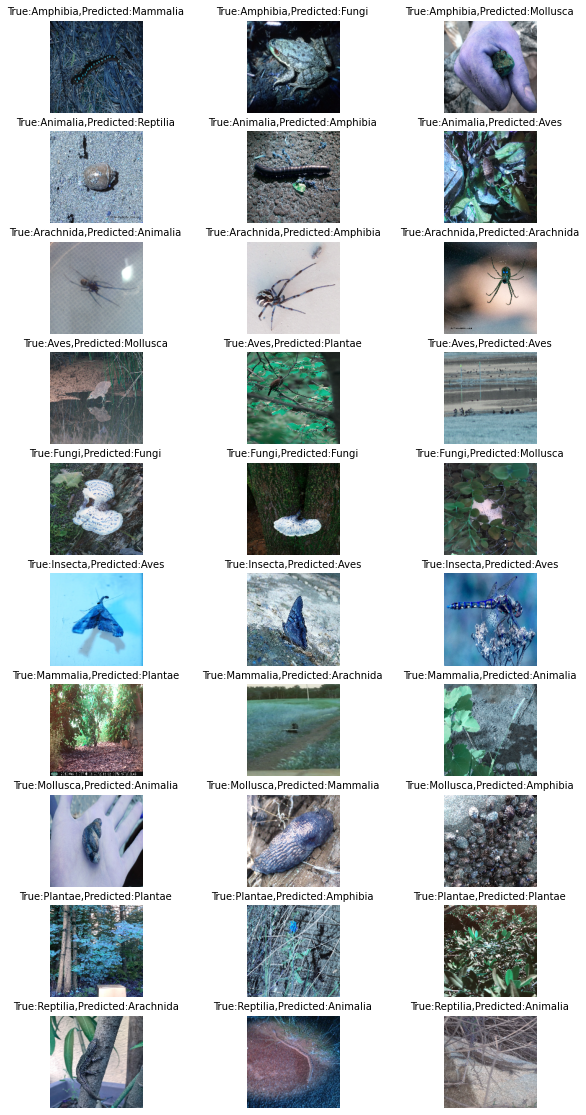

In [ ]:
#taking 30 sample images,3 from each class for visualizing

x,y,y_pred=[],[],[]
for category in categories:
    i=0
    path=os.path.join(test_dir,category)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        x.append(image)
        y.append(category)
        pic = cv2.resize(image, (300,300)) / 255.0
        prediction = model.predict(pic.reshape(1,300, 300,3))
        c=prediction.argmax()
        y_pred.append(categories[c])
        i+=1
      except:
        break

#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(150,150))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+y_pred[k],fontdict={'fontsize':10})
  i+=1   
wandb.init(entity='sanjeev-nimeesh',project='assignment_2')
wandb.log({'predicting on sample images':plt}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


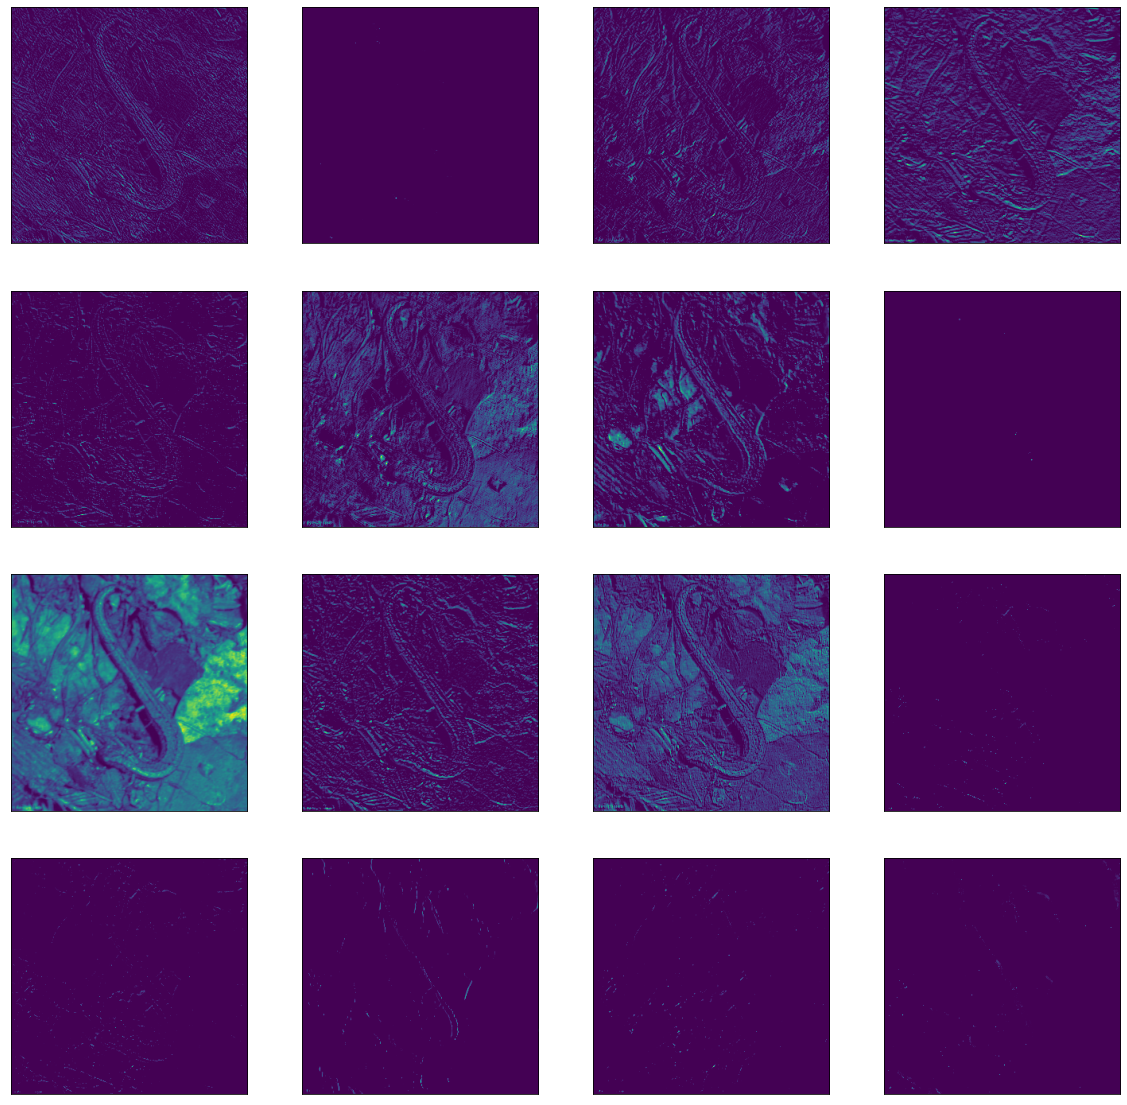

In [ ]:
#visualizing filters

def fil_vis(lay='conv2d_35'):              #name of 1st conv layer
  fil_model = tf.keras.models.Model(
      inputs = [model.inputs],    
      outputs = [model.get_layer(lay).output]
  )
  category = categories[0]
  dir=os.path.join(test_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

      
  
    #f_min, f_max = out.min(), out.max()
    #filters = (out - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # show the figure
    plt.show()
    break

fil_vis()